In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

load data

In [3]:
items = pd.read_csv("data/items.csv")
shops = pd.read_csv("data/shops.csv")
item_cats = pd.read_csv("data/item_categories.csv")
sales = pd.read_csv("data/sales_train.csv")
test = pd.read_csv("data/test.csv")

## Data Cleaning

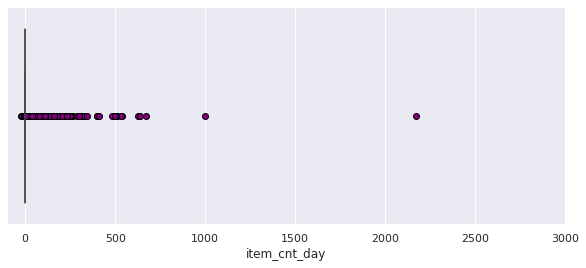

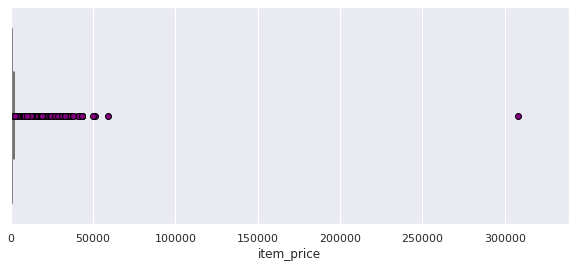

In [6]:
plt.figure(figsize=(10, 4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price, flierprops=flierprops)

In [7]:
sales = sales[(sales.item_price < 300000) & (sales.item_cnt_day < 1000)]

In [8]:
sales = sales[sales.item_price > 0].reset_index(drop = True)
sales.loc[sales.item_cnt_day < 1, "item_cnt_day"] = 0

In [10]:
# Якутск Орджоникидзе, 56
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [11]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])
shops["category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [12]:
shops.head(20)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,"(Плехановская,"
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,Торговля


Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [13]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply(lambda x: x if (x in category) else "other")

In [14]:
shops.head(20)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,other
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,other
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,other


label encoding the category and city

In [15]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform(shops.category)
shops["shop_city"] = LabelEncoder().fit_transform(shops.city)
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [16]:
shops.head()

,shop_id,shop_category,shop_city
0,0,0,29
1,1,4,29
2,2,4,0
3,3,2,1
4,4,4,2


In [17]:
item_cats["type_code"] = item_cats.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
item_cats.loc[ (item_cats.type_code == "Игровые")|(item_cats.type_code == "Аксессуары"), "category"] = "Игры"

In [18]:
category = []
for cat in item_cats.type_code.unique():
    if len(item_cats[item_cats.type_code == cat]) >= 5: 
        category.append(cat)
item_cats.type_code = item_cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [19]:
item_cats.type_code = LabelEncoder().fit_transform(item_cats.type_code)
item_cats["split"] = item_cats.item_category_name.apply(lambda x: x.split("-"))
item_cats["subtype"] = item_cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats["subtype_code"] = LabelEncoder().fit_transform( item_cats["subtype"] )
item_cats = item_cats[["item_category_id", "subtype_code", "type_code"]]

### clean up item data

In [22]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [23]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [25]:
items.head()

,item_name,item_id,item_category_id,name1,name2,name3,type
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,pc
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,0
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d,0
4,коробка,4,40,***КОРОБКА,0,стекло d,0


In [26]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
group_sum

,type,item_id
0,0,17661
1,5c5,1
2,5c7,2
3,5f4,1
4,6dv,1
5,6jv,1
6,6l6,1
7,android,3
8,hm3,1
9,j72,4


In [27]:
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [28]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [29]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    trans = sales[sales.date_block_num == i]
    matrix.append(np.array(list(product([i],trans.shop_id.unique(), trans.item_id.unique())), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols)
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

21.068486213684082

In [30]:
sales["revenue"] = sales["item_cnt_day"] * sales["item_price"]

In [31]:
ts = time.time()
group = sales.groupby( ["date_block_num", "shop_id", "item_id"]).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts


5.558921575546265

In [32]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [33]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.06314730644226074

In [34]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, item_cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

4.446618318557739

In [35]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,4,5
1,0,2,27,1.0,4,0,19,76,42,10,3
2,0,2,28,0.0,4,0,30,107,42,55,3
3,0,2,29,0.0,4,0,23,123,42,16,3
4,0,2,32,0.0,4,0,40,4,42,4,5


In [36]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [37]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


21.449267387390137

In [38]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


11.763064622879028

In [39]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


26.73416805267334

In [40]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


27.032318353652954

In [41]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


40.10176157951355

In [43]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


14.941189050674438

In [44]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


14.89888072013855

In [45]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


23.90838074684143

In [46]:
ts = time.time()
group = sales.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = sales.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


534.05721783638

In [47]:
ts = time.time()
group = sales.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


16.568817377090454

In [48]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [49]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

2.1416993141174316

In [50]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.100843906402588

In [51]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


## Modeling

In [52]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [54]:
data = matrix.copy()
del matrix
gc.collect()

NameError: name 'matrix' is not defined

In [55]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_subtype_avg_item_cnt_lag_1_x,date_shop_subtype_avg_item_cnt_lag_1_y,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
1497465,4,2,27,0.0,4,0,19,76,42,10,...,0.449463,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,0.0,4,0,30,107,42,55,...,0.387207,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,0.0,4,0,23,123,42,16,...,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,0.0,4,0,40,4,42,4,...,0.018585,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,0.0,4,0,37,4,562,1,...,0.035919,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3


In [56]:
data[data["date_block_num"]==34].shape

(214200, 34)

In [57]:
data.to_hdf('data_feat.h5', 'table', append=True)

In [58]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [59]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [60]:
del data
gc.collect()

118

In [61]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[00:50:07] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18201	validation_1-rmse:1.11628
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12741	validation_1-rmse:1.07835
[2]	validation_0-rmse:1.08553	validation_1-rmse:1.04839
[3]	validation_0-rmse:1.04391	validation_1-rmse:1.02269
[4]	validation_0-rmse:1.01276	validation_1-rmse:1.00165
[5]	validation_0-rmse:0.98914	validation_1-rmse:0.98596
[6]	validation_0-rmse:0.96469	validation_1-rmse:0.97179
[7]	validation_0-rmse:0.94021	validation_1-rmse:0.95822
[8]	validation_0-rmse:0.92117	validation_1-rmse:0.94669
[9]	validation_0-rmse:0.90818	validation_1-rmse:0.93961
[10]	validation_0-rmse:0.89478	validation_1-rmse:0.93320
[11]	va

2123.2562444210052

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

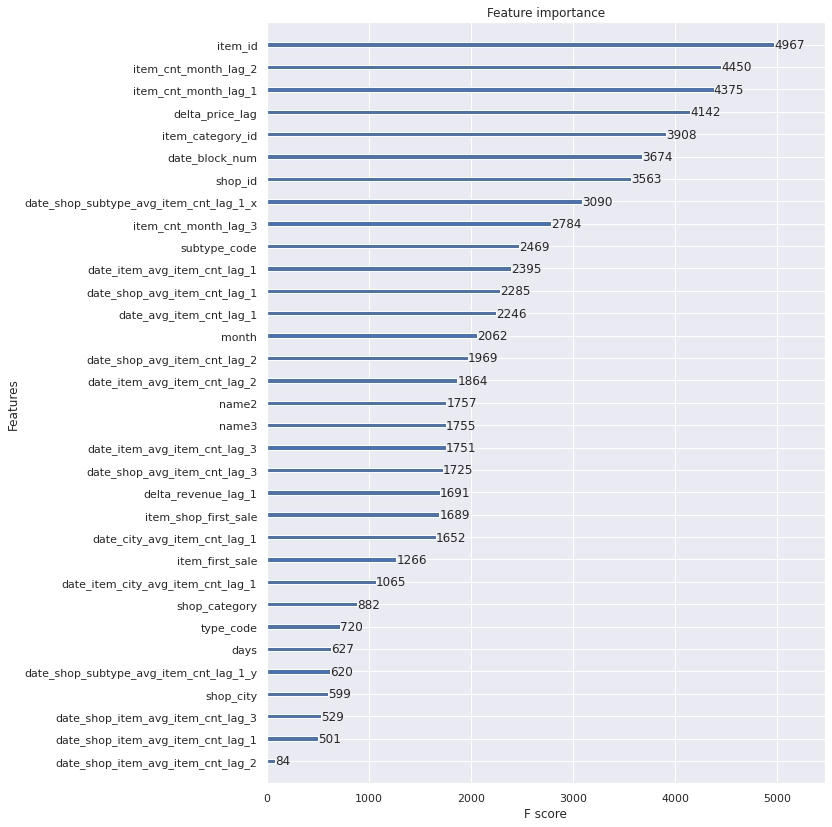

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [64]:
model.save_model('xgboost_20200802.model') 